In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [3]:
#read in data
def readdata(fname):
    hyperspec = pd.read_csv(fname, delimiter = ',', header=0, dtype = np.float64)
    return hyperspec

In [4]:
#converts wavelength to energy, averages reflectance data, performs Kulbelka-Munk transformation, plots data for reference
def dataconvert(hsdata):
    Energy = (1/(hsdata[hsdata.keys()[0]]/2.998e17))*4.1357e-15
    Energy = Energy[::-1]
    avg = hsdata[hsdata.keys()[1:]].mean(axis=1)
    Refavg = avg[::-1]
    FRavg = (1-Refavg)**2/(2*Refavg)
    indirectavg = (FRavg*Energy)**0.5
    directavg = (FRavg*Energy)**2
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(Energy,directavg,'o')
    ax1.set_title('Direct Bandgap')
    ax2.plot(Energy,indirectavg,'o')
    ax2.set_title('Indirect Bandgap')
    return [Energy, FRavg, directavg, indirectavg]

In [5]:
#Tauc plot fitting to determine direct/indirect band gap based on the limits given in terms of energy
def manualbandgap(hsdata, lim1, lim2):
    x = hsdata[0]
    diry = hsdata[2]
    indiry = hsdata[3]
    LinearEnergy = []
    LinearDirect = []
    LinearIndirect = []
    for k in range(len(x)):
        if lim1 < x[k] < lim2:
            LinearEnergy.append(x[k])
            LinearDirect.append(diry[k])
    directcoef = np.polyfit(LinearEnergy,LinearDirect,deg=1)
    directpoly1d_fn = np.poly1d(directcoef)
    LinearIndirect = []
    for k in range(len(x)):
        if lim1 < x[k] < lim2:
            LinearIndirect.append(indiry[k])
    indirectcoef = np.polyfit(LinearEnergy,LinearIndirect,deg=1)
    indirectpoly1d_fn = np.poly1d(indirectcoef)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(x, diry, 'yo', x, directpoly1d_fn(x), '--k')
    ax1.set_title('Direct Bandgap')
    ax1.set_xlim(min(x),max(x))
    ax1.set_ylim(0,max(diry))
    ax2.plot(x,indiry, 'yo', x, indirectpoly1d_fn(x), '--k')
    ax2.set_title('Indirect Bandgap')
    ax2.set_xlim(min(x),max(x))
    ax2.set_ylim(0,max(indiry))
    print('Direct Bandgap is', directcoef[1]/np.negative(directcoef[0]), 'Indirect Bangap is', indirectcoef[1]/np.negative(indirectcoef[0]))
    return [directcoef[0], directcoef[1], indirectcoef[0], indirectcoef[1]]

In [6]:
#does above 3 functions all together
def automatedbandgap(fname, lim1, lim2):
    hyperspec = pd.read_csv(fname, delimiter = ',', header=0, dtype = np.float64)
    hsdata = dataconvert(hyperspec)
    return manualbandgap(hsdata, lim1, lim2), hsdata

In [7]:
#automatically performs data conversion and Tauc plot fitting 
#for series of data sets using one set of limits for the linear region
#exports the data for plotting outside of python
def autoHype(path,lim1,lim2):
    spectra = {}
    for file in Path(path).glob('*.csv'):
        spectra.update({str(file):[]})
    for s in spectra:
        spectra[s].append(automatedbandgap(s,lim1,lim2))
    for s in spectra:
        line = spectra[s][0][1][0]*spectra[s][0][0][0]+spectra[s][0][0][1]
        np.savetxt(s+'-Linear-Fit',line)
        np.savetxt(s+'-Energy',spectra[s][0][1][0]) #Saves Energy
        np.savetxt(s+'-Direct',spectra[s][0][1][2]) #Saves Direct Bandgap Refl
        np.savetxt(s+'-Indirect',spectra[s][0][1][2]) #Save Indirect Bandgap Refl
    plt.figure()
    for s in spectra:
        plt.scatter(spectra[s][0][0][1]/(-spectra[s][0][0][0]),spectra[s][0][0][2]/(-spectra[s][0][0][3]),label=s)
    plt.xlabel('Direct')
    plt.ylabel('Indirect')
    plt.legend()
    return spectra

Direct Bandgap is 2.4255576363387656 Indirect Bangap is 1.263742190074094
Direct Bandgap is 2.701682316964172 Indirect Bangap is 2.4077064967502384
Direct Bandgap is 2.7107700359436158 Indirect Bangap is 2.449588877352139
Direct Bandgap is 2.2390049599867696 Indirect Bangap is 0.5103544648988626
Direct Bandgap is 2.5864459100020856 Indirect Bangap is 1.9147644415724852
Direct Bandgap is 2.468489811262235 Indirect Bangap is 1.488438605134925


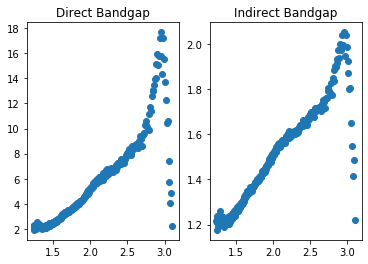

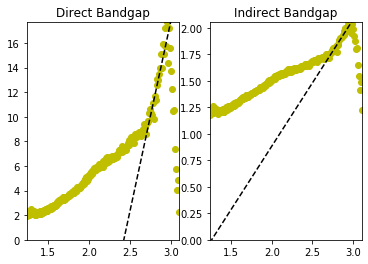

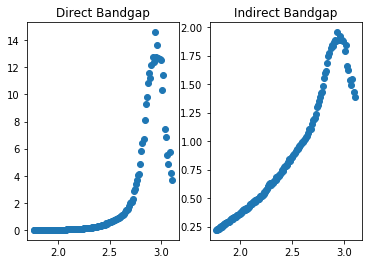

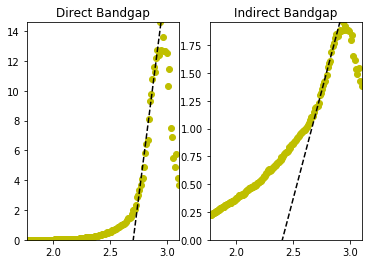

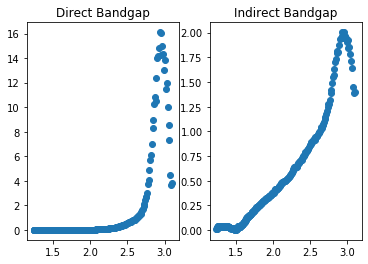

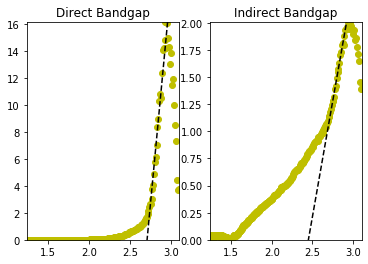

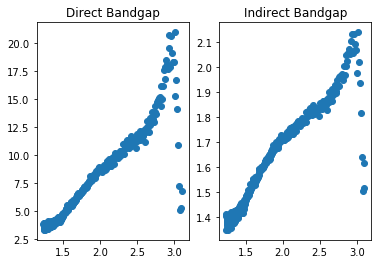

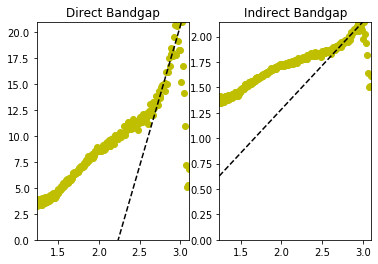

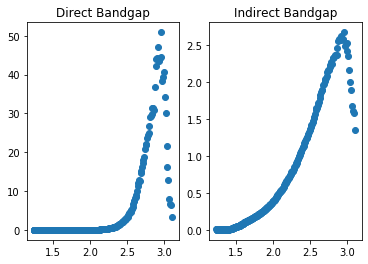

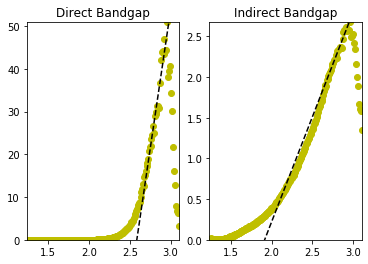

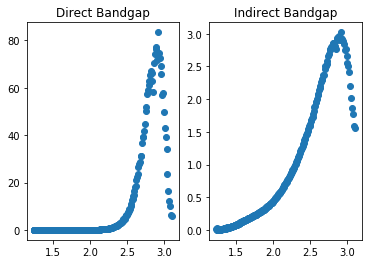

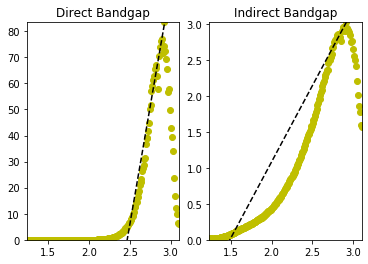

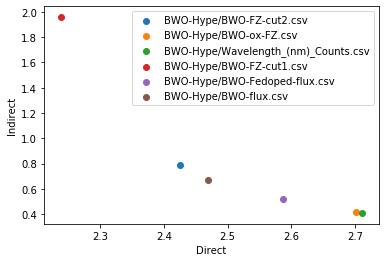

In [8]:
spectra = autoHype('.',2.725,2.9)

In [9]:
#find the intersection between two lines
def get_intersection(m1,b1,m2,b2):
    A = np.array([[-m1, 1], [-m2, 1]])
    b = np.array([[b1], [b2]])
    # you have to solve linear System AX = b where X = [x y]'
    X = np.linalg.pinv(A) @ b
    x, y = np.round(np.squeeze(X), 4)
    return x, y # returns point of intersection (x,y) with 4 decimal precision

In [10]:
#this corrects a data set if there is absorption outside of the linear region to get the "true" band gap
def manualbandgapcorrected(hsdata, lim1, lim2, lim3, lim4):
    x = hsdata[0]
    diry = hsdata[2]
    indiry = hsdata[3]
    LinearEnergy = []
    LinearDirect = []
    LinearIndirect = []
    LinearEnergy2 = []
    LinearDirect2 = []
    LinearIndirect2 = []
    for k in range(len(x)):
        if lim1 < x[k] < lim2:
            LinearEnergy.append(x[k])
            LinearDirect.append(diry[k])
    directcoef = np.polyfit(LinearEnergy,LinearDirect,deg=1)
    directpoly1d_fn = np.poly1d(directcoef)
    LinearIndirect = []
    for k in range(len(x)):
        if lim1 < x[k] < lim2:
            LinearIndirect.append(indiry[k])
    indirectcoef = np.polyfit(LinearEnergy,LinearIndirect,deg=1)
    indirectpoly1d_fn = np.poly1d(indirectcoef)
    for k in range(len(x)):
        if lim3 < x[k] < lim4:
            LinearEnergy2.append(x[k])
            LinearDirect2.append(diry[k])
    directcoef2 = np.polyfit(LinearEnergy2,LinearDirect2,deg=1)
    directpoly1d_fn2 = np.poly1d(directcoef2)
    LinearIndirect = []
    for k in range(len(x)):
        if lim3 < x[k] < lim4:
            LinearIndirect2.append(indiry[k])
    indirectcoef2 = np.polyfit(LinearEnergy2,LinearIndirect2,deg=1)
    indirectpoly1d_fn2 = np.poly1d(indirectcoef2)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(x, diry, 'yo', x, directpoly1d_fn(x), '--k', x, directpoly1d_fn2(x),'--k')
    ax1.set_title('Direct Bandgap')
    ax1.set_xlim(min(x),max(x))
    ax1.set_ylim(0,max(diry))
    ax2.plot(x,indiry, 'yo', x, indirectpoly1d_fn(x), '--k', x, indirectpoly1d_fn2(x),'--k')
    ax2.set_title('Indirect Bandgap')
    ax2.set_xlim(min(x),max(x))
    ax2.set_ylim(0,max(indiry))
    dbg=get_intersection(directcoef[0],directcoef[1],directcoef2[0],directcoef2[1])
    ibg=get_intersection(indirectcoef[0],indirectcoef[1],indirectcoef2[0],indirectcoef2[1])
    print('Direct Bandgap is', dbg[0], 'Indirect Bangap is', ibg[0])
    np.savetxt('Corrected-linearfit1',directpoly1d_fn(x))
    np.savetxt('Corrected-linearfit2',directpoly1d_fn2(x))
    return [directcoef[1]/np.negative(directcoef[0]), indirectcoef[1]/np.negative(indirectcoef[0]),dbg[0],ibg[0]]

Direct Bandgap is 2.724 Indirect Bangap is 2.7299


[2.2896289956949487, 0.6642556187472147, 2.724, 2.7299]

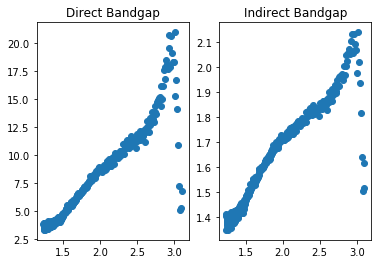

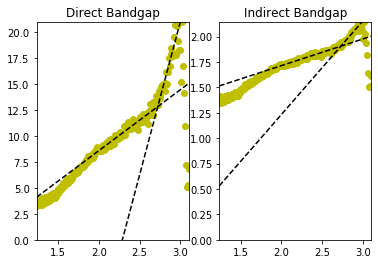

In [14]:
manualbandgapcorrected(dataconvert(readdata('BWO-FZ-cut1.csv')),2.75,2.9,2,2.5)